In [5]:


import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import os
from glob import glob
import re
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import math
import plotly.graph_objects as go



In [7]:
def get_image(image_path):
    return cv2.imread(image_path)

In [8]:
image = get_image('./Dataset/game1/Clip1/0000.jpg')

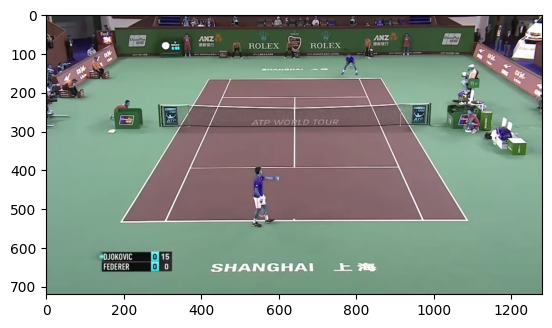

In [9]:
plt.imshow(image)

In [ ]:
# Mouse callback function to collect points
points=[]
cv2.imshow('Select Points', image)
def get_points(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        print("Point selected: ({}, {})".format(x, y))

# Set the mouse callback
cv2.setMouseCallback('Select Points', get_points)

# Wait for the user to select points
cv2.waitKey(0)

# Close the image window
cv2.destroyAllWindows()

# Print the selected points
print("Selected Points:", points)

In [10]:
# top left corner, top right corner, bottom right corner, bottom left corner, pole left, pole right
points=[(420, 165), (860, 165), (1090, 530), (200, 530), (291, 230), (992, 230)]
#plot points on frame
for point in points:
    cv2.circle(image, point, 5, (0, 0, 255), -1)
cv2.imshow('points',image)
cv2.waitKey(0)

# Close the image window
cv2.destroyAllWindows()



In [1]:
#true coords
# top left corner, top right corner, bottom right corner, bottom left corner, pole left, pole right
true_coords = [(0,23.77, 0), (10.97,23.77,  0), (10.97,0, 0),(0,0,0), (-0.91, 11.88,1.07), (11.42,11.88,1.07)]

In [11]:
A = []
for i in range(6):
    X, Y, Z = true_coords[i]
    u, v = points[i]
    A.append([X, Y, Z, 1, 0, 0, 0, 0, -u*X, -u*Y, -u*Z, -u])
    A.append([0, 0, 0, 0, X, Y, Z, 1, -v*X, -v*Y, -v*Z, -v])

In [12]:
A = np.array(A)


In [13]:
image.shape

(720, 1280, 3)

In [14]:
# svd of A
U, S, V = np.linalg.svd(A)

In [15]:
V.shape

(12, 12)

In [16]:
# get last column of V
p = V[-1, :]

In [17]:
p.shape

(12,)

In [18]:
# reshape to 
M3D = np.reshape(p, (3, 4))

In [19]:
M3D

array([[ 1.39384656e-01,  4.69474443e-02, -5.70743579e-02,
         3.43606669e-01],
       [ 2.75172915e-15, -1.41844360e-02, -1.66509395e-01,
         9.10557674e-01],
       [ 2.68331553e-17,  7.39200488e-05, -1.35088539e-04,
         1.71803335e-03]])

In [20]:
a1 = M3D[0, :3]
a2 = M3D[1, :3]
a3 = M3D[2, :3]
b1 = M3D[0, 3]
b2 = M3D[1, 3]
b3 = M3D[2, 3]

In [21]:
rho = 1 / np.linalg.norm(a3)
cx = rho**2 * np.dot(a1, a3)
cy = rho**2 * np.dot(a2, a3)
cos_theta = -np.dot(np.cross(a1, a3), np.cross(a2, a3)) / (np.linalg.norm(np.cross(a1, a3)) * np.linalg.norm(np.cross(a2, a3)))
sin_tetha = np.sqrt(1 - cos_theta**2)
alpha = rho**2 * np.linalg.norm(np.cross(a1, a3)) * sin_tetha
beta = rho**2 * np.linalg.norm(np.cross(a2, a3)) * sin_tetha

In [22]:
cy

904.3528009912231

In [23]:
K = np.array([[alpha, -alpha* (cos_theta/sin_tetha), cx], [0, beta/ sin_tetha, cy], [0, 0, 1]])
#K = np.array([[alpha, 0, cx], [0, alpha, cy], [0, 0, 1]])

In [24]:
K

array([[905.15075942, -89.53378157, 471.4885489 ],
       [  0.        , 599.8602068 , 904.35280099],
       [  0.        ,   0.        ,   1.        ]])

In [25]:
# get R and T
r1 = (np.cross(a2, a3) / np.linalg.norm(np.cross(a2, a3)))
r3= rho * a3
r2 = np.cross(r3, r1)

In [26]:
b = np.array([b1, b2, b3])
t = rho* np.linalg.inv(K).dot(b)

In [27]:
# use K R and t to project the points in 3d and show with matplotlib
points_2d = np.array(points)
# add 1 to the points
points_2d = np.hstack((points_2d, np.ones((6, 1))))
points_2d


array([[4.20e+02, 1.65e+02, 1.00e+00],
       [8.60e+02, 1.65e+02, 1.00e+00],
       [1.09e+03, 5.30e+02, 1.00e+00],
       [2.00e+02, 5.30e+02, 1.00e+00],
       [2.91e+02, 2.30e+02, 1.00e+00],
       [9.92e+02, 2.30e+02, 1.00e+00]])

In [28]:
R = np.array([r1, r2, r3])

In [29]:
t = t.reshape(3, 1)
t

array([[-4.03503228],
       [-6.96255398],
       [11.15674588]])

In [30]:
points_normalized = np.linalg.inv(K) @ points_2d.T
points_3d = (np.linalg.inv(R) @ (points_normalized - t)).T


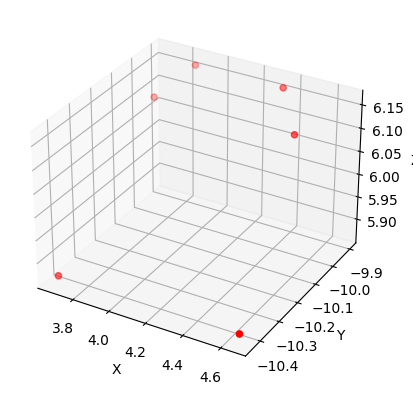

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='r', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [32]:
x = points_3d[:, 0]
y = points_3d[:, 1]
z = points_3d[:, 2]

# Create Plotly figure
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5))])

# Set axes labels
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))

# Show plot
fig.show()

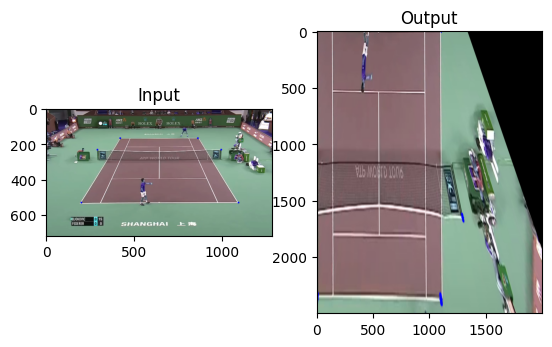

In [33]:
rows,cols,ch = image.shape

pts1 = np.float32([[420, 165], [860, 165], [1090, 530], [200, 530]])

ratio=0.02
cardH=math.sqrt((pts1[2][0]-pts1[1][0])*(pts1[2][0]-pts1[1][0])+(pts1[2][1]-pts1[1][1])*(pts1[2][1]-pts1[1][1]))
cardW=ratio*cardH
pts2 = np.float32([[0,2377], [1097,2377], [1097,0],[0,0]])

M = cv2.getPerspectiveTransform(pts1,pts2)

offsetSize=20
transformed = np.zeros((int(cardW+offsetSize), int(cardH+offsetSize)), dtype=np.uint8);
dst = cv2.warpPerspective(image, M, (2000,2500))

plt.subplot(121),plt.imshow(image),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

In [34]:
rectified_pts = cv2.perspectiveTransform(pts1.reshape(-1, 1, 2), M)

# Print the coordinates of original points in the new rectified image
for point in rectified_pts:
    x, y = point[0]
    print("Original Point: ({}, {}) -> New Rectified Image: ({}, {})".format(pts1[0][0], pts1[0][1], x, y))

Original Point: (420.0, 165.0) -> New Rectified Image: (2.4450455765948065e-13, 2377.0)
Original Point: (420.0, 165.0) -> New Rectified Image: (1097.0, 2377.0)
Original Point: (420.0, 165.0) -> New Rectified Image: (1097.0, 0.0)
Original Point: (420.0, 165.0) -> New Rectified Image: (1.2087866243983697e-13, -2.4175732487967394e-13)


In [35]:
point1= np.float32([420, 165, 1])
corenr=np.dot(M , point1)
corner= corenr/corenr[2]
corner

array([2.44504569e-13, 2.37700000e+03, 1.00000000e+00])

In [36]:
rectified_pts

array([[[ 2.4450456e-13,  2.3770000e+03]],

       [[ 1.0970000e+03,  2.3770000e+03]],

       [[ 1.0970000e+03,  0.0000000e+00]],

       [[ 1.2087866e-13, -2.4175732e-13]]], dtype=float32)

In [37]:
d_3pts = []
for point in rectified_pts:
    x, y = point[0]
    point_3d = np.array([x, y, 1])
    #point_3d = np.dot(np.linalg.inv(M), point_3d)
    d_3pts.append(point_3d)
d_3pts
    

[array([2.44504558e-13, 2.37700000e+03, 1.00000000e+00]),
 array([1.097e+03, 2.377e+03, 1.000e+00]),
 array([1.097e+03, 0.000e+00, 1.000e+00]),
 array([ 1.20878662e-13, -2.41757325e-13,  1.00000000e+00])]

In [38]:
d_3pts = np.array(d_3pts)

In [39]:
x = d_3pts[:, 0]
y = d_3pts[:, 1]
z = d_3pts[:, 2]

# Create Plotly figure
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5))])
#connect the 4 points
fig.add_trace(go.Scatter3d(x=[x[0], x[1]], y=[y[0], y[1]], z=[z[0], z[1]], mode='lines', name='top'))
fig.add_trace(go.Scatter3d(x=[x[1], x[2]], y=[y[1], y[2]], z=[z[1], z[2]], mode='lines', name='right'))
fig.add_trace(go.Scatter3d(x=[x[2], x[3]], y=[y[2], y[3]], z=[z[2], z[3]], mode='lines', name='bottom'))
fig.add_trace(go.Scatter3d(x=[x[3], x[0]], y=[y[3], y[0]], z=[z[3], z[0]], mode='lines', name='left'))

# Set axes labels
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))

# Show plot
fig.show()

In [40]:
d_3pts= np.array(d_3pts)

In [41]:
points_normalized = np.linalg.inv(K) @ d_3pts.T
points_3d = (np.linalg.inv(R) @ (points_normalized - t)).T

In [42]:
points_3d

array([[  3.75697413, -13.1370964 ,   4.38932866],
       [  4.96892693, -13.1370964 ,   4.38932866],
       [  4.57696388,  -9.66090576,   6.29148989],
       [  3.36501107,  -9.66090576,   6.29148989]])

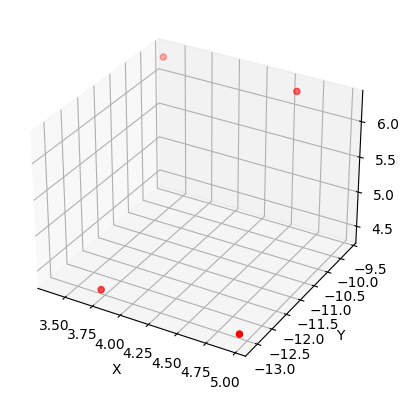

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='r', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [44]:
x = points_3d[:, 0]
y = points_3d[:, 1]
z = points_3d[:, 2]

# Create Plotly figure
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5))])
#connect the 4 points
fig.add_trace(go.Scatter3d(x=[x[0], x[1]], y=[y[0], y[1]], z=[z[0], z[1]], mode='lines', name='top'))
fig.add_trace(go.Scatter3d(x=[x[1], x[2]], y=[y[1], y[2]], z=[z[1], z[2]], mode='lines', name='right'))
fig.add_trace(go.Scatter3d(x=[x[2], x[3]], y=[y[2], y[3]], z=[z[2], z[3]], mode='lines', name='bottom'))
fig.add_trace(go.Scatter3d(x=[x[3], x[0]], y=[y[3], y[0]], z=[z[3], z[0]], mode='lines', name='left'))

# Set axes labels
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))

# Show plot
fig.show()

In [41]:
# calcula the distance between the 2 points
def distance_3d(point1, point2):
    return np.linalg.norm(point1[:2] - point2[:2])
for i in range(4):
    for j in range(i+1, 4):
        print("Distance between point {} and point {} is: {}".format(i, j, distance_3d(points_3d[i], points_3d[j])))

Distance between point 0 and point 1 is: 2.4829778217977547
Distance between point 0 and point 2 is: 16.256386884780447
Distance between point 0 and point 3 is: 16.18927891011029
Distance between point 1 and point 2 is: 16.189278910110296
Distance between point 1 and point 3 is: 16.499871103681418
Distance between point 2 and point 3 is: 2.4829778217977543


In [42]:
ball_coordinates= pd.read_csv('../outcsv/ball_track.csv')    

NameError: name 'pd' is not defined

In [ ]:
# get ball coordinates as an matrix of points
ball_points = ball_coordinates[['x', 'y']].values
#convert to float32
ball_points = np.array(ball_points, dtype=np.float32)
rectified_pts_ball = cv2.perspectiveTransform(ball_points.reshape(-1, 1, 2), M)
x = rectified_pts_ball[:, 0, 0]
y = rectified_pts_ball[:, 0, 1]
# bring the rectified points in 3d
d_3pts = []
for point in rectified_pts_ball:
    x, y = point[0]
    point_3d = np.array([x, y, 1])
    #point_3d = np.dot(np.linalg.inv(M), point_3d)
    d_3pts.append(point_3d)
d_3pts
d_3pts = np.array(d_3pts)
points_normalized = np.linalg.inv(K) @ d_3pts.T
points_3d = (np.linalg.inv(R) @ (points_normalized - t)).T
x = d_3pts[:, 0]
y = d_3pts[:, 1]
z = d_3pts[:, 2]

# Create Plotly figure
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5))])

fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))

# Show plot
fig.show()
# Print the coordinates of original points in the new rectified image
# for point in rectified_pts_ball:
#     x, y = point[0]
#     #plot with cv2
#     cv2.circle(dst, (int(x), int(y)), 5, (0, 0, 255), -1)
#     # show image
#     cv2.imshow('points',dst)
#     if cv2.waitKey(100) & 0xFF == ord('q'):
#             break
# cv2.destroyAllWindows()



In [ ]:
d_3pts

array([[ 1.24050342e+03,  2.60488477e+03,  1.00000000e+00],
       [ 1.24050342e+03,  2.60488477e+03,  1.00000000e+00],
       [ 1.24050342e+03,  2.60488477e+03,  1.00000000e+00],
       [ 9.59598572e+02,  1.62926721e+03,  1.00000000e+00],
       [ 7.71520325e+02,  9.76047974e+02,  1.00000000e+00],
       [ 6.83821716e+02,  5.91759827e+02,  1.00000000e+00],
       [ 6.14416748e+02,  2.87632843e+02,  1.00000000e+00],
       [ 5.58122070e+02,  4.09538727e+01,  1.00000000e+00],
       [ 4.78647095e+02, -2.17420471e+02,  1.00000000e+00],
       [ 4.78647095e+02, -2.17420471e+02,  1.00000000e+00],
       [ 4.27075134e+02, -2.56367706e+02,  1.00000000e+00],
       [ 3.95478180e+02, -2.75306274e+02,  1.00000000e+00],
       [ 3.64454742e+02, -2.93901062e+02,  1.00000000e+00],
       [ 3.16757385e+02, -3.30096161e+02,  1.00000000e+00],
       [ 3.19155701e+02, -3.22960754e+02,  1.00000000e+00],
       [ 2.17164764e+02, -4.87284271e+02,  1.00000000e+00],
       [ 2.17164764e+02, -4.87284271e+02

In [43]:
# height rectification
# Mouse callback function to collect points
points=[]
cv2.imshow('Select Points', image)
def get_points(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        print("Point selected: ({}, {})".format(x, y))

# Set the mouse callback
cv2.setMouseCallback('Select Points', get_points)

# Wait for the user to select points
cv2.waitKey(0)

# Close the image window
cv2.destroyAllWindows()

# Print the selected points
print("Selected Points:", points)

Selected Points: []


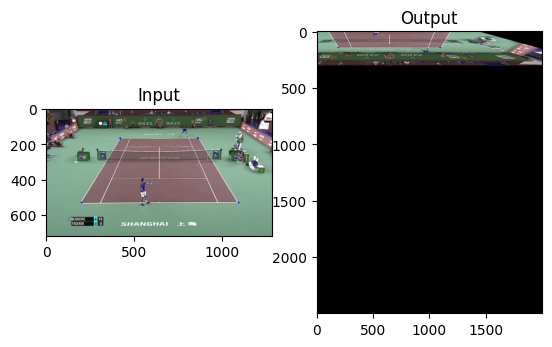

In [44]:
rows,cols,ch = image.shape

pts1 = np.float32([[290, 230], [990, 230],  [190, 530], [1090, 530]])

ratio=0.02
cardH=math.sqrt((pts1[2][0]-pts1[1][0])*(pts1[2][0]-pts1[1][0])+(pts1[2][1]-pts1[1][1])*(pts1[2][1]-pts1[1][1]))
cardW=ratio*cardH
pts2 = np.float32([[0,107], [1279,107],  [91, 0],[1188,0]])

M = cv2.getPerspectiveTransform(pts1,pts2)

offsetSize=20
transformed = np.zeros((int(cardW+offsetSize), int(cardH+offsetSize)), dtype=np.uint8);
dst = cv2.warpPerspective(image, M, (2000,2500))

plt.subplot(121),plt.imshow(image),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

In [45]:
rectified_pts_ball = cv2.perspectiveTransform(ball_points.reshape(-1, 1, 2), M)

# Print the coordinates of original points in the new rectified image
for point in rectified_pts_ball:
    x, y = point[0]
    #plot with cv2
    cv2.circle(dst, (int(x), int(y)), 5, (0, 0, 255), -1)
    # show image
    cv2.imshow('points',dst)
    if cv2.waitKey(100) & 0xFF == ord('q'):
            break
cv2.destroyAllWindows()

NameError: name 'ball_points' is not defined

In [46]:
def plot_heigth(dst, ball_points, M):
        rectified_pts_ball = cv2.perspectiveTransform(ball_points.reshape(-1, 1, 2), M)

        # Print the coordinates of original points in the new rectified image
        for point in rectified_pts_ball:
            x, y = point[0]
            #plot with cv2
            cv2.circle(dst, (int(x), int(y)), 5, (0, 0, 255), -1)
            # show image
            cv2.imshow('points',dst)
            if cv2.waitKey(100) & 0xFF == ord('q'):
                    break
        cv2.destroyAllWindows()

In [102]:
ball_points

array([[ 904.5,  148.5],
       [ 904.5,  148.5],
       [ 904.5,  148.5],
       [ 837. ,  232.5],
       [ 769.5,  316.5],
       [ 730.5,  383.5],
       [ 691.5,  450.5],
       [ 652.5,  517.5],
       [ 583.5,  604.5],
       [ 583.5,  604.5],
       [ 535.5,  619.5],
       [ 505.5,  627. ],
       [ 475.5,  634.5],
       [ 427.5,  649.5],
       [ 430.5,  646.5],
       [ 307.5,  721.5],
       [ 307.5,  721.5],
       [ 321. ,  687. ],
       [ 334.5,  652.5],
       [ 373.5,  589.5],
       [ 370.5,  595.5],
       [ 478.5,  442.5],
       [ 478.5,  442.5],
       [ 499.5,  409.5],
       [ 520.5,  376.5],
       [ 559.5,  322.5],
       [ 559.5,  322.5],
       [ 610.5,  265.5],
       [ 631.5,  229.5],
       [ 631.5,  229.5],
       [ 670.5,  184.5],
       [ 691.5,  163.5],
       [ 694.5,  163.5],
       [ 736.5,  124.5],
       [ 751.5,  109.5],
       [ 751.5,  109.5],
       [ 787.5,   85.5],
       [ 805.5,   73.5],
       [ 811.5,   91.5],
       [ 838.5,   58.5],


In [49]:
rectified_pts_ball

array([[[1198.5715   ,  157.40779  ]],

       [[1198.5715   ,  157.40779  ]],

       [[1198.5715   ,  157.40779  ]],

       [[ 997.9565   ,  105.66891  ]],

       [[ 846.35205  ,   66.569916 ]],

       [[ 771.2231   ,   41.62373  ]],

       [[ 708.34625  ,   20.745808 ]],

       [[ 654.95044  ,    3.0159929]],

       [[ 575.8913   ,  -16.372475 ]],

       [[ 575.8913   ,  -16.372475 ]],

       [[ 523.63336  ,  -19.371136 ]],

       [[ 491.49075  ,  -20.836668 ]],

       [[ 459.82755  ,  -22.280344 ]],

       [[ 410.8113   ,  -25.104042 ]],

       [[ 413.37524  ,  -24.545961 ]],

       [[ 305.24814  ,  -37.578632 ]],

       [[ 305.24814  ,  -37.578632 ]],

       [[ 308.364    ,  -31.813055 ]],

       [[ 311.6899   ,  -25.658852 ]],

       [[ 334.7849   ,  -13.280173 ]],

       [[ 333.26733  ,  -14.52861  ]],

       [[ 421.48074  ,   23.057934 ]],

       [[ 421.48074  ,   23.057934 ]],

       [[ 441.81244  ,   33.09635  ]],

       [[ 463.93887  ,   44.020893 ]],



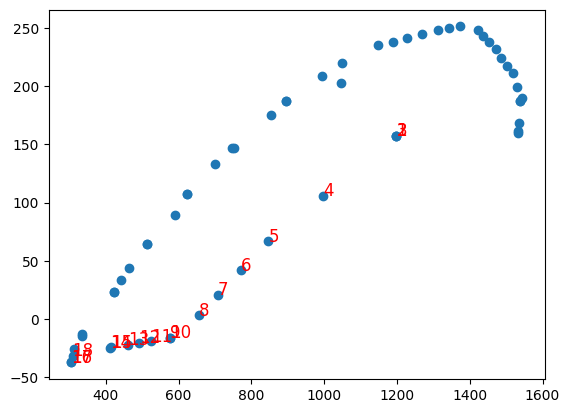

In [50]:
#plot a chart of the points
x = rectified_pts_ball[:, 0, 0]
y = rectified_pts_ball[:, 0, 1]
# along with each poitn plot a number from 1 to size of points array
for i in range(18):
    plt.text(x[i], y[i], str(i+1), color='red', fontsize=12)


plt.scatter(x, y)

In [51]:
# bring the rectified points in 3d
d_3pts = []
for point in rectified_pts_ball:
    x, y = point[0]
    point_3d = np.array([x, y, 1])
    #point_3d = np.dot(np.linalg.inv(M), point_3d)
    d_3pts.append(point_3d)
d_3pts

[array([1.19857153e+03, 1.57407791e+02, 1.00000000e+00]),
 array([1.19857153e+03, 1.57407791e+02, 1.00000000e+00]),
 array([1.19857153e+03, 1.57407791e+02, 1.00000000e+00]),
 array([997.95648193, 105.66890717,   1.        ]),
 array([846.35205078,  66.56991577,   1.        ]),
 array([771.2230835 ,  41.62372971,   1.        ]),
 array([708.34625244,  20.74580765,   1.        ]),
 array([654.95043945,   3.01599288,   1.        ]),
 array([575.89129639, -16.37247467,   1.        ]),
 array([575.89129639, -16.37247467,   1.        ]),
 array([523.63336182, -19.37113571,   1.        ]),
 array([491.49075317, -20.83666801,   1.        ]),
 array([459.82754517, -22.28034401,   1.        ]),
 array([410.81130981, -25.10404205,   1.        ]),
 array([413.37524414, -24.54596138,   1.        ]),
 array([305.24813843, -37.57863235,   1.        ]),
 array([305.24813843, -37.57863235,   1.        ]),
 array([308.36401367, -31.81305504,   1.        ]),
 array([311.68991089, -25.65885162,   1.      

In [52]:
d_3pts = np.array(d_3pts)

In [53]:
points_normalized = np.linalg.inv(K) @ d_3pts.T
points_3d = (np.linalg.inv(R) @ (points_normalized - t)).T

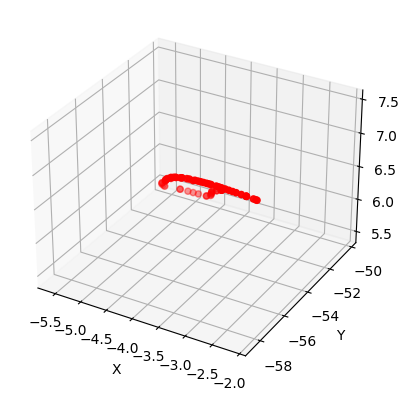

In [102]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='r', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [103]:
x = d_3pts[:, 0]
y = d_3pts[:, 1]
z = d_3pts[:, 2]

# Create Plotly figure
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5))])
#connect the 4 points
# fig.add_trace(go.Scatter3d(x=[x[0], x[1]], y=[y[0], y[1]], z=[z[0], z[1]], mode='lines', name='top'))
# fig.add_trace(go.Scatter3d(x=[x[1], x[2]], y=[y[1], y[2]], z=[z[1], z[2]], mode='lines', name='right'))
# fig.add_trace(go.Scatter3d(x=[x[2], x[3]], y=[y[2], y[3]], z=[z[2], z[3]], mode='lines', name='bottom'))
# fig.add_trace(go.Scatter3d(x=[x[3], x[0]], y=[y[3], y[0]], z=[z[3], z[0]], mode='lines', name='left'))

# Set axes labels
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))

# Show plot
fig.show()

In [104]:
d_3pts

array([[ 1.11980725e+03,  2.52991531e+02,  1.00000000e+00],
       [ 1.11980725e+03,  2.52991531e+02,  1.00000000e+00],
       [ 1.11980725e+03,  2.52991531e+02,  1.00000000e+00],
       [ 9.97001404e+02,  1.00652542e+02,  1.00000000e+00],
       [ 8.74195618e+02, -5.16864395e+01,  1.00000000e+00],
       [ 8.03241089e+02, -1.73194916e+02,  1.00000000e+00],
       [ 7.32286621e+02, -2.94703400e+02,  1.00000000e+00],
       [ 6.61332153e+02, -4.16211853e+02,  1.00000000e+00],
       [ 5.35797302e+02, -5.73991516e+02,  1.00000000e+00],
       [ 5.35797302e+02, -5.73991516e+02,  1.00000000e+00],
       [ 4.48468719e+02, -6.01194885e+02,  1.00000000e+00],
       [ 3.93888336e+02, -6.14796631e+02,  1.00000000e+00],
       [ 3.39307953e+02, -6.28398315e+02,  1.00000000e+00],
       [ 2.51979370e+02, -6.55601685e+02,  1.00000000e+00],
       [ 2.57437408e+02, -6.50161011e+02,  1.00000000e+00],
       [ 3.36578941e+01, -7.86177979e+02,  1.00000000e+00],
       [ 3.36578941e+01, -7.86177979e+02

In [2]:
np.rad2deg(np.pi*0.15)

27.0

In [57]:
bounces = pd.read_csv('./../bounce.csv')

In [58]:
bounces.head()

,x,y,bounce
0,519.0,449.0,0
1,519.0,449.0,0
2,519.0,449.0,0
3,523.0,445.0,0
4,533.0,441.0,0


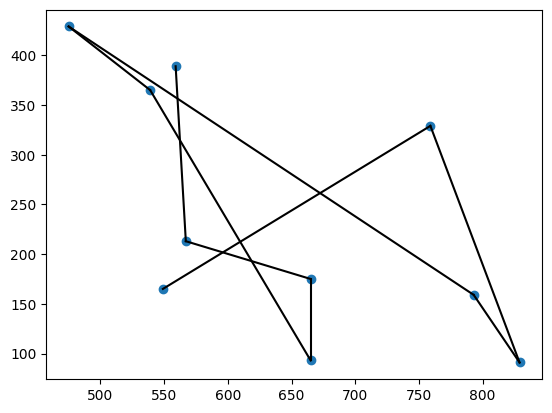

In [63]:
# plot the bounce points
true_bounce = bounces[bounces['bounce']==1]

x = np.asarray(true_bounce['x'])
y = np.asarray(true_bounce['y'])
plt.scatter(x, y)

#plot line between consecutive points
for i in range(1, len(x)):
    plt.plot([x[i-1], x[i]], [y[i-1], y[i]], 'k-')

Bounce on player at point: (559.0, 389.0)
Bounce on player at point: (665.0, 93.0)
Bounce on player at point: (475.0, 429.0)
Bounce on player at point: (829.0, 91.0)
Bounce on player at point: (759.0, 329.0)


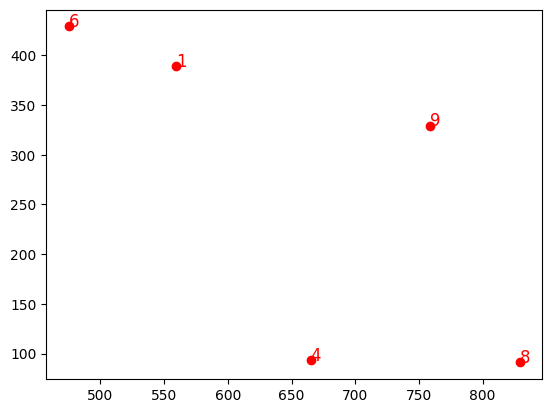

In [66]:
criteria= 0 # 0 minore 1 maggiore
#understand if the ball is going up or down
if y[0] < y[1]:
    criteria = 1


for i in range(len(y)-1):
    if criteria == 1:
        if y[i+1] > y[i]:
            print("Bounce on player at point: ({}, {})".format(x[i], y[i]))
            plt.scatter(x[i], y[i], c='r')
            # add i label
            plt.text(x[i], y[i], str(i+1), color='red', fontsize=12)
            criteria = 0
    if criteria == 0:
        if y[i+1] < y[i]:
            print("Bounce on player at point: ({}, {})".format(x[i], y[i]))
            plt.scatter(x[i], y[i], c='r')
            plt.text(x[i], y[i], str(i+1), color='red', fontsize=12)
            criteria = 1

In [68]:
# detect player coordinates
def motion_comp(prev_frame, curr_frame, num_points=500, points_to_use=500, transform_type='affine'):
    """ Obtains new warped frame1 to account for camera (ego) motion
        Inputs:
            prev_frame - first image frame
            curr_frame - second sequential image frame
            num_points - number of feature points to obtain from the images
            points_to_use - number of point to use for motion translation estimation 
            transform_type - type of transform to use: either 'affine' or 'homography'
        Outputs:
            A - estimated motion translation matrix or homography matrix
            prev_points - feature points obtained on previous image
            curr_points - feature points obtaine on current image
        """
    transform_type = transform_type.lower()
    assert(transform_type in ['affine', 'homography'])

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_RGB2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_RGB2GRAY)

    # get features for first frame
    corners = cv2.goodFeaturesToTrack(prev_gray, num_points, qualityLevel=0.01, minDistance=10)

    # get matching features in next frame with Sparse Optical Flow Estimation
    matched_corners, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, corners, None)

    # reformat previous and current corner points
    prev_points = corners[status==1]
    curr_points = matched_corners[status==1]

    # sub sample number of points so we don't overfit
    if points_to_use > prev_points.shape[0]:
        points_to_use = prev_points.shape[0]

    index = np.random.choice(prev_points.shape[0], size=points_to_use, replace=False)
    prev_points_used = prev_points[index]
    curr_points_used = curr_points[index]

    # find transformation matrix from frame 1 to frame 2
    if transform_type == 'affine':
        A, _ = cv2.estimateAffine2D(prev_points_used, curr_points_used, method=cv2.RANSAC)
    elif transform_type == 'homography':
        A, _ = cv2.findHomography(prev_points_used, curr_points_used)

    return A, prev_points, curr_points

In [120]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

player_xy=[]

def player_pipeline(path):
    # frame_files = sorted([f for f in os.listdir(path) if f.endswith('.jpg')])


    # first_frame_path = os.path.join(path, frame_files[0])
    # prev = cv2.imread(first_frame_path)
    
    #get frames from video
    cap = cv2.VideoCapture(path)
    ret, prev = cap.read()
    print(ret)
    bounding_boxes = []
    t=1
    while ret:
        
        # Read the frame
        #frame_path = os.path.join(path, frame_file)
        ret, frame = cap.read()
        
        if frame is None:
            break

        A, prev_points, curr_points = motion_comp(prev, frame, num_points=10000, points_to_use=10000, transform_type='affine')
        transformed1 = cv2.warpAffine(prev, A, dsize=(prev.shape[:2][::-1]))
        comped_delta = cv2.subtract(frame, transformed1)
        comped_delta = cv2.cvtColor(comped_delta, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(comped_delta, 70, 250, cv2.THRESH_BINARY)
        dilated = cv2.dilate(thresh, kernel, iterations=1)

        numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilated, connectivity=8, ltype=cv2.CV_32S)
        
        if len(centroids)>1:

            # Perform hierarchical clustering on component centers
            clusterer = AgglomerativeClustering(n_clusters=None, distance_threshold=52, linkage='single')
            clusters = clusterer.fit_predict(centroids)

            # Draw bounding boxes around clustered component centers
            output = frame.copy()
            #create a data structure to store the bounding boxes
            
            
            # maxarea so far
            max_area = 0
            # found player
            found_player = False
            # index of maxarea
            index = 0
            
            for cluster_id in np.unique(clusters):
                cluster_indices = np.where(clusters == cluster_id)[0]
                cluster_centers = centroids[cluster_indices]
                min_x = int(np.min(cluster_centers[:, 0]))
                min_y = int(np.min(cluster_centers[:, 1]))
                max_x = int(np.max(cluster_centers[:, 0]))
                max_y = int(np.max(cluster_centers[:, 1]))

                # Calculate area of the bounding box
                area = (max_x - min_x) * (max_y - min_y)
                

                if area > 1000:
                    cv2.rectangle(output, (min_x - 5, min_y - 5), (max_x + 5, max_y + 5), (255, 0, 0), 2)
                    
                    # Draw center
                    center_x, center_y = (min_x + max_x) // 2, (min_y + max_y) // 2
                    cv2.circle(output, (center_x, center_y), 4, (0, 255, 0), -1)

                    # Add label
                    cv2.putText(output, 'Player', (min_x, min_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                    found_player = True
                    # store bounding box in dict, min_x, min_y, max_x, max_y t
                    bounding_boxes.append([min_x, min_y, max_x, max_y, t])
                    
                elif area > max_area:
                    max_area = area
                    index = cluster_id
            # if found polayer is false then add the max area bounding box
            if found_player == False:
                cluster_indices = np.where(clusters == index)[0]
                cluster_centers = centroids[cluster_indices]
                min_x = int(np.min(cluster_centers[:, 0]))
                min_y = int(np.min(cluster_centers[:, 1]))
                max_x = int(np.max(cluster_centers[:, 0]))
                max_y = int(np.max(cluster_centers[:, 1]))

                # Calculate area of the bounding box
                area = (max_x - min_x) * (max_y - min_y)
                cv2.rectangle(output, (min_x - 5, min_y - 5), (max_x + 5, max_y + 5), (255, 0, 0), 2)
                    
                # Draw center
                center_x, center_y = (min_x + max_x) // 2, (min_y + max_y) // 2
                cv2.circle(output, (center_x, center_y), 4, (0, 255, 0), -1)

                # Add label
                cv2.putText(output, 'Player', (min_x, min_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                # store bounding box in dict, min_x, min_y, max_x, max_y t
                bounding_boxes.append([min_x, min_y, max_x, max_y, t])
                    

            cv2.imshow("Output", output)
        else:
            cv2.imshow("Output", frame)
        prev = frame.copy()
        t+=1

        if cv2.waitKey(5) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()
    return bounding_boxes

In [121]:
bounding_boxes=player_pipeline('/Users/Gloria/Desktop/LABS/TennisBounceDetector/g5c1.mp4')

True


In [122]:
bounding_boxes

[[463, 358, 517, 449, 1],
 [478, 357, 492, 447, 2],
 [473, 412, 522, 481, 3],
 [470, 355, 529, 441, 4],
 [464, 355, 533, 447, 5],
 [460, 355, 539, 446, 6],
 [458, 355, 558, 446, 7],
 [457, 356, 560, 457, 8],
 [464, 339, 560, 459, 9],
 [465, 316, 560, 499, 10],
 [466, 295, 560, 504, 11],
 [471, 324, 530, 503, 12],
 [414, 369, 517, 513, 13],
 [472, 368, 513, 495, 14],
 [418, 505, 461, 531, 14],
 [424, 374, 521, 529, 15],
 [429, 359, 544, 526, 16],
 [404, 302, 547, 524, 17],
 [467, 302, 501, 379, 18],
 [410, 427, 551, 521, 18],
 [412, 317, 542, 517, 19],
 [415, 320, 540, 515, 20],
 [475, 376, 530, 514, 21],
 [1, 657, 106, 688, 22],
 [480, 369, 559, 519, 22],
 [484, 307, 533, 511, 23],
 [397, 317, 559, 513, 24],
 [409, 302, 561, 517, 25],
 [415, 296, 549, 515, 26],
 [391, 420, 551, 518, 27],
 [478, 310, 532, 372, 27],
 [465, 327, 552, 444, 28],
 [395, 426, 448, 468, 28],
 [513, 427, 550, 513, 29],
 [401, 427, 446, 459, 29],
 [483, 336, 548, 379, 29],
 [497, 293, 559, 509, 30],
 [416, 211, 

In [123]:
# create a dataframe with the bounding boxes and the time
bounding_boxes = pd.DataFrame(bounding_boxes, columns=['min_x', 'min_y', 'max_x', 'max_y', 'time'])

In [124]:
bounding_boxes

,min_x,min_y,max_x,max_y,time
0,463,358,517,449,1
1,478,357,492,447,2
2,473,412,522,481,3
3,470,355,529,441,4
4,464,355,533,447,5
...,...,...,...,...,...
277,638,250,684,359,186
278,634,249,674,359,187
279,582,243,678,359,188
280,581,241,669,359,189


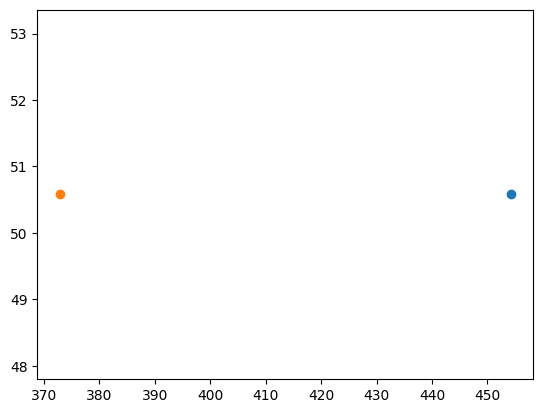

In [126]:
time_bounding_boxes = bounding_boxes[bounding_boxes['time']==1]
max_x_i = time_bounding_boxes[['max_x','min_y']].values
min_x_i = time_bounding_boxes[['min_x','min_y']].values
    
# convert to float32
max_x_i = np.array(max_x_i, dtype=np.float32)
min_x_i = np.array(min_x_i, dtype=np.float32)
# transform in homogeneous coordinates
#max_x_i = np.hstack((max_x_i, np.ones((max_x_i.shape[0], 1))))
#min_x_i = np.hstack((min_x_i, np.ones((min_x_i.shape[0], 1))))
rectified_pts_max = cv2.perspectiveTransform(max_x_i.reshape(-1, 1, 2), M)
rectified_pts_min = cv2.perspectiveTransform(min_x_i.reshape(-1, 1, 2), M)

# scatter plot of the points
x = rectified_pts_max[:, 0, 0]
y = rectified_pts_max[:, 0, 1]
plt.scatter(x, y)

x_1 = rectified_pts_min[:, 0, 0]
y_1 = rectified_pts_min[:, 0, 1]
plt.scatter(x_1, y_1)

In [111]:
max_time = bounding_boxes['time'].max()

for i in range(1,max_time+1):
    # get the bounding boxes for the time i
    time_bounding_boxes = bounding_boxes[bounding_boxes['time']==i]
    max_x_i = time_bounding_boxes[['max_x','min_y']].values
    min_x_i = time_bounding_boxes[['min_x','min_y']].values
    
    # convert to float32
    max_x_i = np.array(max_x_i, dtype=np.float32)
    min_x_i = np.array(min_x_i, dtype=np.float32)
    # transform in homogeneous coordinates
    #max_x_i = np.hstack((max_x_i, np.ones((max_x_i.shape[0], 1))))
    #min_x_i = np.hstack((min_x_i, np.ones((min_x_i.shape[0], 1))))
    rectified_pts_max = cv2.perspectiveTransform(max_x_i.reshape(-1, 1, 2), M)
    rectified_pts_min = cv2.perspectiveTransform(min_x_i.reshape(-1, 1, 2), M)
    
   # scatter plot of the points
    x = rectified_pts_max[:, 0, 0]
    y = rectified_pts_max[:, 0, 1]
    plt.scatter(x, y)

    x_1 = rectified_pts_min[:, 0, 0]
    y_1 = rectified_pts_min[:, 0, 1]
    plt.scatter(x_1, y_1)
    

In [130]:
max_time = bounding_boxes['time'].max()

# Define the size of the plot
width, height = 500, 900

# Create a window
cv2.namedWindow('Animation', cv2.WINDOW_NORMAL)

for i in range(1, max_time + 1):
    # Create a blank image
    img = np.ones((height, width, 3), dtype=np.uint8) * 255
    
    # Get the bounding boxes for the current time frame
    time_bounding_boxes = bounding_boxes[bounding_boxes['time'] == i]
    max_x_i = time_bounding_boxes[['max_x', 'min_y']].values
    min_x_i = time_bounding_boxes[['min_x', 'min_y']].values
    
    # Convert to float32
    max_x_i = np.array(max_x_i, dtype=np.float32)
    min_x_i = np.array(min_x_i, dtype=np.float32)
    
    # Transform in homogeneous coordinates
    rectified_pts_max = cv2.perspectiveTransform(max_x_i.reshape(-1, 1, 2), M)
    rectified_pts_min = cv2.perspectiveTransform(min_x_i.reshape(-1, 1, 2), M)
    
    # Plot the points on the image
    for pt in rectified_pts_max:
        x, y = int(pt[0][0]), int(pt[0][1])
        cv2.circle(img, (x, y), 5, (255, 0, 0), -1)  # Blue circles for max points
    
    for pt in rectified_pts_min:
        x, y = int(pt[0][0]), int(pt[0][1])
        cv2.circle(img, (x, y), 5, (0, 0, 255), -1)  # Red circles for min points
    
    # Display the image
    cv2.imshow('Animation', img)
    
    # Delay for a short period to create animation effect
    if cv2.waitKey(200) & 0xFF == ord('q'):
        break

# Release the window
cv2.destroyAllWindows()